(chap_pixel_size)=
(chap_dimensions)=
# Pixel size & dimensions

:::{admonition} Chapter outline 
:class: tip

* The concept of **pixel size** relates measurements in pixels to physical units
* It can be helpful to think of pixels as little squares -- but this is a simplification
* The number of **dimensions** of an image is the number of pieces of information required to identify each pixel 
:::

In [1]:
%load_ext autoreload
%autoreload 2

# Default import
import sys
sys.path.append('../../../')
from helpers import *

import numpy as np
from matplotlib import pyplot as plt

## Introduction

Hopefully by now you're appropriately nervous about accidentally changing pixel values and therefore compromising your image's integrity.
If in doubt, you'll always calculate histograms or other measurements before and after trying out something new, to check whether the pixels have been changed. 

This chapter explores pixels in more detail, including how they are arranged within an image and how they relate to things in the physical world.

## Pixel size

**How big is a pixel?**

In one sense, a pixel is just a number: it doesn't really have a size at all.
However, if we don't get too philosophical about it[^philosophy], we intuitively know that the things depicted in our images usually have a size in real life.

[^philosophy]: If we *do* get too philosophical about it, I would expect there to be issues with 'know', 'size' and 'real life' -- and probably many other elements of that sentence.

The 'pixel size' is an idea that helps us translate measurements we make in images to the sizes and positions of things in real life.
We often need to know the pixel size for our images if our analysis results are be meaningful.

One way to think about this in microscopy is to consider the **field of view** of an image, i.e. the width and height of the area that has been imaged.
We can divide the width and height in physical units (often µm) by the number of pixels along that dimension, as shown in {numref}`fig-px_sizes`.

The result is that we have two value in µm/px, corresponding to the **pixel width** and **pixel height**.
*Usually* these are the same.

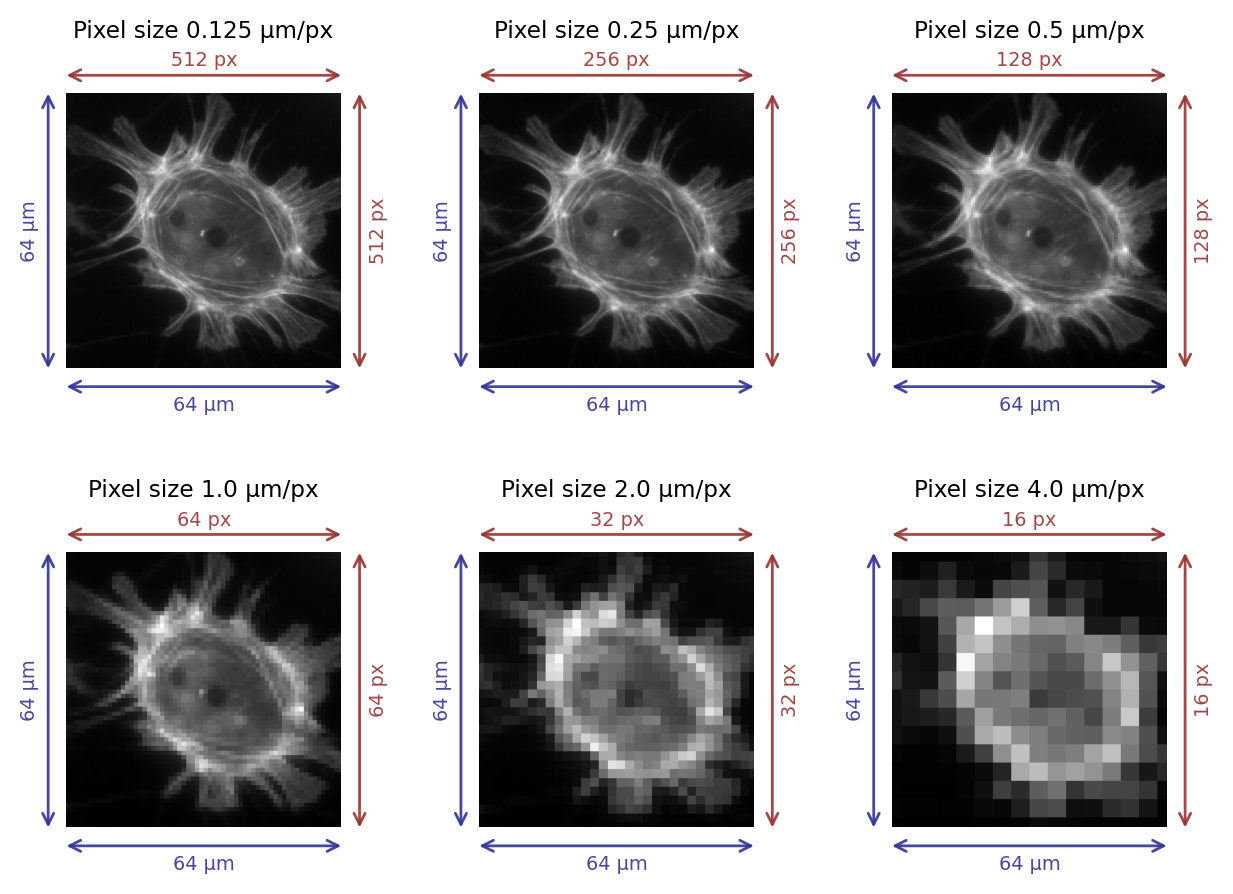

In [2]:
# Crop center of an image to a target shape (sz,sz)
im_orig = load_image('sunny_cell.tif')
sz = 600
r = (im_orig.shape[0]-sz) // 2
c = (im_orig.shape[1]-sz) // 2
im_orig = im_orig[r:r+sz, c:c+sz, ...]

from skimage.transform import downscale_local_mean, resize
from scipy.ndimage import zoom
im_orig = resize(im_orig, (512, 512))

fig = create_figure()
n_plots = 6
for ii in range(n_plots):
    
    # Downscale if we need to
    if ii > 0:
        im = downscale_local_mean(im_orig, (2**ii, 2**ii))
    else:
        im = im_orig.copy()
    
    # Compute image and pixel sizes
    len_pixels = im.shape[0]
    len_microns = 64
    pixel_size = len_microns/len_pixels
    
    # Show the image
    # We need to 'zoom' it to be the same size as the original so that the 
    # arrows line up exactly across figures
    s = im_orig.shape[0]
    show_image(zoom(im, 2**ii, order=0), pos=(2, 3, ii+1))
    color_pixels = (0.6, 0.2, 0.2, 0.9)
    color_microns = (0.2, 0.2, 0.6, 0.9)

    arrow_args = dict(
        xycoords='data',
        arrowprops=dict(arrowstyle="<->", shrinkA=0, shrinkB=0, color=color_pixels),
        annotation_clip=False,
        text=""
    )
    text_args = dict(
        fontsize='x-small'
    )
    offset = s/15
    
    plt.annotate(xy=(0,-offset), xytext=(s,-offset), **arrow_args)
    plt.text(s/2, -offset*1.5, f'{len_pixels} px', ha='center', **text_args, color=color_pixels)

    plt.annotate(xy=(s+offset,0), xytext=(s+offset,s), **arrow_args, color=color_pixels)
    plt.text(s+offset*1.5, s/2, f'{len_pixels} px', **text_args, va='center', ha='left', rotation='vertical', color=color_pixels)

    arrow_args['arrowprops']['color'] = color_microns
    plt.annotate(xy=(0,s+offset), xytext=(s,s+offset), **arrow_args)
    plt.text(s/2, s+offset*1.5, f'{len_microns} µm', va='top', ha='center', **text_args, color=color_microns)

    plt.annotate(xy=(-offset,0), xytext=(-offset,s), **arrow_args)
    plt.text(-offset*1.5, s/2, f'{len_microns} µm', **text_args, va='center', ha='right', rotation='vertical', color=color_microns)
    
    plt.title(f'Pixel size {pixel_size} µm/px', pad=20, fontsize='small')

plt.tight_layout(pad=1.5)
plt.show()

glue_fig('fig_pixel_size', fig)

```{glue:figure} fig_pixel_size
---
align: center
figwidth: 90%
name: fig-px_sizes
---

Images with different pixel sizes.
Whenever the field of view remains the same, the pixel size increases as the number of pixels in the image decreases.
```

```{figure} images/not_squares.png
:align: center
:width: 80%
:figclass: margin

[A Pixel is *Not* a Little Square](http://alvyray.com/Memos/CG/Microsoft/6_pixel.pdf)
```

:::{admonition} Pixel squareness 
:class: info

Talking of pixels as having (usually) equal widths and heights makes them sound very square-like, but previously I stated that pixels are not squares -- they are just displayed using squares. 

This slightly murky philosophical distinction is considered in Alvy Ray Smith's technical memo (_right_), the title of which gives a good impression of the central argument.
In short, pushing the pixels-are-square model too far leads to confusion in the end (e.g. what would happen at their 'edges'?), and does not really match up to the realities of how images are recorded (i.e. pixel values are not determined by detecting light emitted from little square regions, see {ref}`chap_formation_spatial`).
Alternative terms, such as _sampling distance_, are often used instead of pixel size -- and are potentially less misleading.

But 'pixel size' is still used commonly in software (including ImageJ), and we will use the term as a useful shorthand.
::: 

### Pixel sizes and measurements 

Knowing the pixel size makes it possible to calibrate size measurements. For example, if we measure some structure horizontally in the image and find that it is 10 pixels in length, with a pixel size of 0.5µm, we can deduce that its actual length in reality is (approximately!) 10 × 0.5µm = 5µm. 

This conversion is often done within the analysis software, but depends upon the pixel size information being present and correct.
All being well, appropriate pixel sizes will have been written into an image file during acquisition and subsequently read by the software.
Unfortunately, this does not always work out (see {ref}`chap_files`) and so we do always need to check our pixel sizes, and derived measurements of size, for reasonableness.

`````{tab-set}

````{tab-item} Question
Suppose we detect a structure and we count that it covers an area spanning 10 pixels.
Suppose also that the pixel width = 2.0 µm and the pixel height is 2.0 µm.

What is the **area** of the structure in µm<sup>2</sup>?
````

````{tab-item} Answer
40 µm<sup>2</sub>

At least that's the answer I was looking for: 10 x 2µm x 2µm = 40µm<sup>2</sup>.

If you want to be pedantic about it, you might quibble about whether it makes sense to report 2D areas for 3D structures, or the possible impact of measurement error caused by the diffraction limit.

But let's not be pedantic for now.
````
`````

### Pixel sizes and detail 

In general, if the pixel size in a microscopy image is large then we cannot see very fine detail (see {numref}`fig-px_sizes`).
However, the subject becomes complicated by the diffraction of light whenever we are considering scales of hundreds of nanometers, so that acquiring images with smaller pixel sizes does not necessarily bring us extra information -- and might even become a hindrance. 

This will be explored in more detail in {ref}`chap_formation_spatial` and {ref}`chap_formation_noise`.

## Dimensions

### Identifying dimensions 

The concept of **image dimensions** is *mostly* straightforward, although I'm not aware of any universal definition that all people and all software stick to reliably.

The approach we'll take here is to say: **the number of dimensions is the number of pieces of information you need to know to identify an individual pixel.** 

For example, in the most familiar 2D images, we can uniquely identify a pixel if we know its _x_ and _y_ spatial coordinates.

But if we needed to know _x_ and _y_ coordinates, a _z_-slice number, a color channel and a time point then we would be working with 5D data ({numref}`fig-dimensions`).
We could throw away one of these dimensions -- any one at all -- and get a 4D image, and keep going until we have a single pixel remaining: a 0D image.

Throw away that pixel, and we no longer have an image.

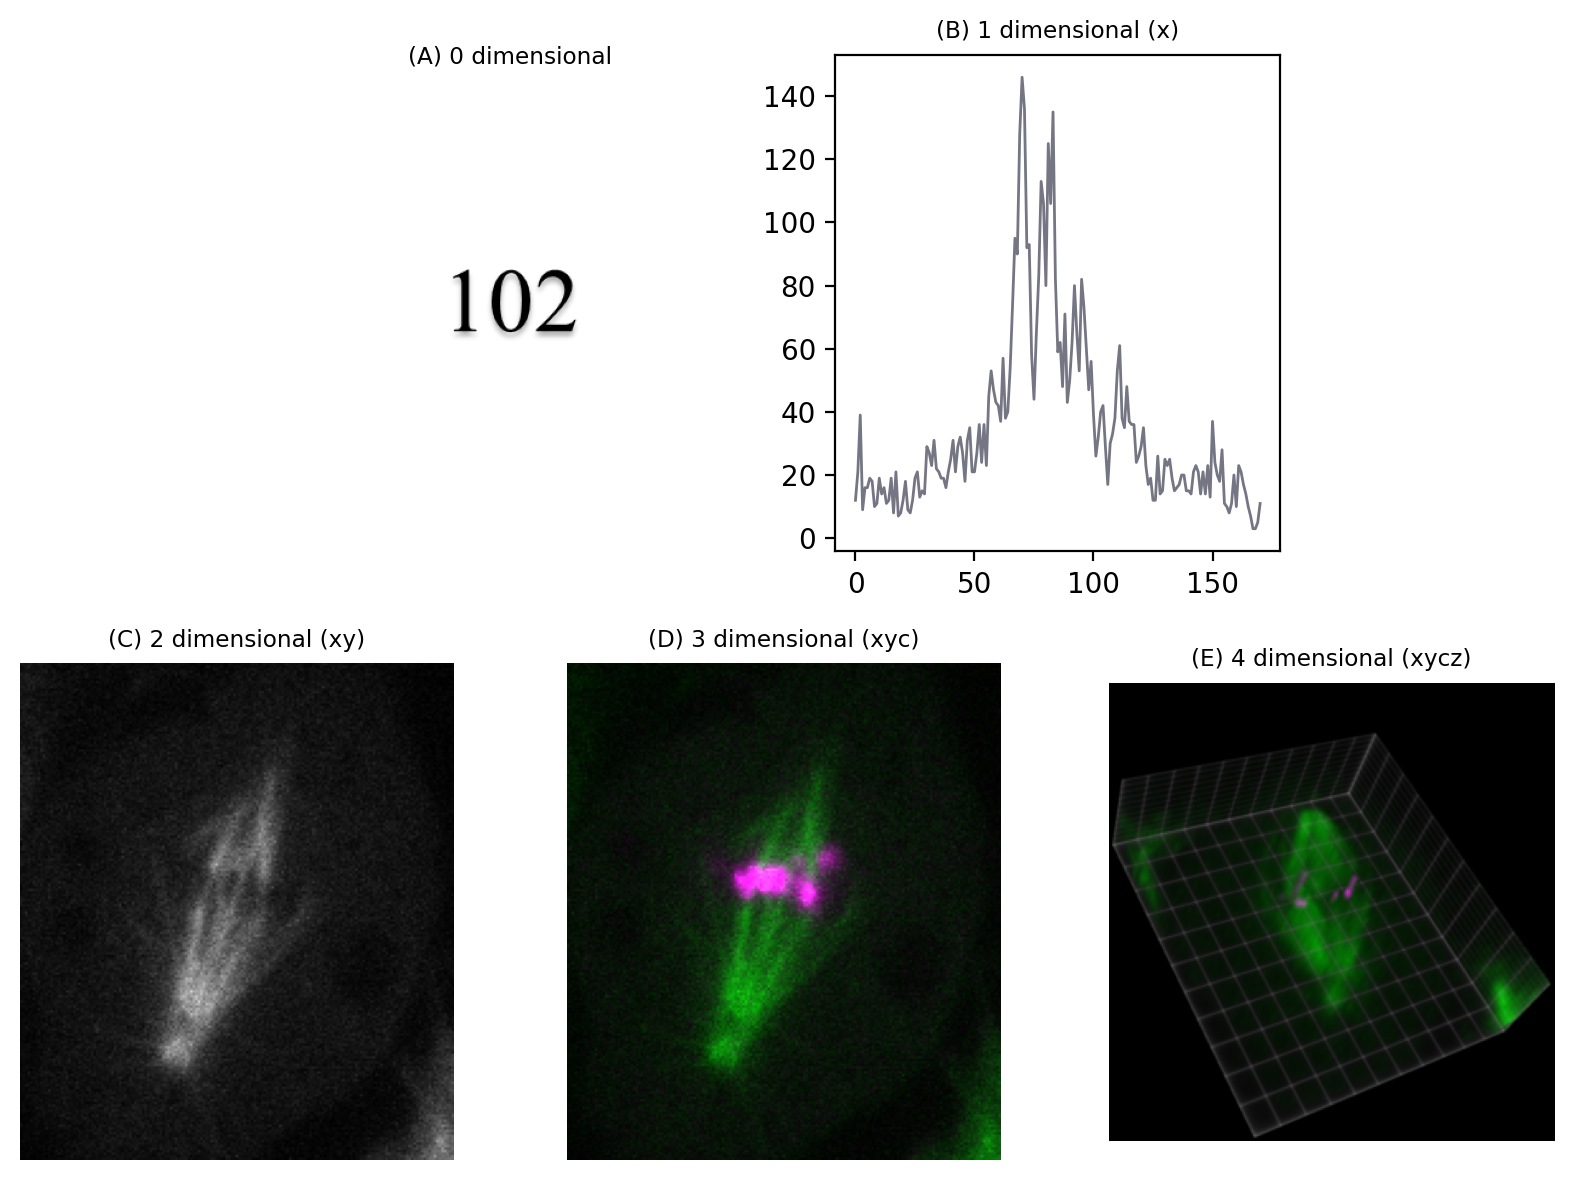

In [3]:
fig = create_figure(figsize=(8, 6))
im_full = load_image('mitosis-single.zip', volume=True)
im_full = np.moveaxis(im_full, 1, -1)
im_full = im_full.astype(np.float32)
im_full = im_full - np.percentile(im_full, 0.1)
im_full /= np.percentile(im_full, 99.9)
im_full = np.clip(im_full * 255, 0, 255).astype(np.uint8)

im_3d = np.squeeze(im_full[im_full.shape[0]//2, ...])
im_3d = np.flipud(im_3d)
im_2d = np.squeeze(im_3d[..., 1])
im_1d = np.squeeze(im_2d[im_2d.shape[0]//2, ...])
im_0d = np.squeeze(im_1d[im_1d.shape[0]//2, ...])

from matplotlib import gridspec

gs = gridspec.GridSpec(2, 6)

ax = plt.subplot(gs[0, 1:3])
show_image('images/dims_0.png', title='(A) 0 dimensional', axes=ax)
ax = plt.subplot(gs[0, 3:5])
show_plot(im_1d, title='(B) 1 dimensional (x)', axes=ax)
ax = plt.subplot(gs[1, 0:2])
show_image(im_2d, vmin=0, vmax=255, title='(C) 2 dimensional (xy)', axes=ax)
ax = plt.subplot(gs[1, 2:4])
show_image(create_rgb(im_3d, colors=['magenta', 'green'], axis=-1), title='(D) 3 dimensional (xyc)', axes=ax)
ax = plt.subplot(gs[1, 4:6])
show_image('images/mitosis4d.png', title='(E) 4 dimensional (xycz)', axes=ax)

plt.tight_layout()
glue_fig('fig_dimensions', fig)

```{glue:figure} fig_dimensions
---
align: center
name: fig-dimensions
---

Depictions of images with different numbers of dimensions. (A) A single value is considered to have 0 dimensions. (B--E) Additional dimensions are added, here in the following order: _x_ coordinate (1), _y_ coordinate (2), channel number (3), _z_ slice (4). The volume view in (E) was generated using the [ClearVolume plugin for Fiji](https://imagej.net/plugins/clearvolume).
``` 

```{margin}
Loic A. Royer et al. (2015). "ClearVolume – Open-source live 3D visualization for light sheet microscopy". *Nature Methods* 12, 480–481. https://doi.org/10.1038/nmeth.3372
```

```{figure} ./images/mitosis.gif
---
align: center
name: fig-dimensions-5f
---
Visualization of a 5D image (xyczt) using ClearVolume + Fiji. 
```


In principle, therefore, 2D images do not need to have *x* and *y* dimensions.
The dimensions could be *x* and *z*, or *y* and time, for example.
But while we may play around with the identity of dimensions, the important fact remains: an *nD* image requires *n* pieces of information to identify each pixel. 

:::{admonition} Do channels really add a dimension?
:class: important

There can be some fuzziness in the idea of dimensions, particularly when channels are involved.
If we rigorously follow the approach above, an image with *x*, *y* and *channels* would be 3D... but in practice such images are often (but not always!) called 2D anyway.

'3D' is sometimes restricted to mean that there is a *z* dimension.
If we have an image with *x*, *y* and *time* then we might technically be correct to call it 3D -- but that is likely to be confusing, so it's probably best to refer to a 'time series' instead.

I still think that our explanation of the number of dimensions as being 'the number of things you need to know to identify a pixel' is a good baseline way to think about it, and corresponds well with the implementation in software and usage in Python/NumPy.
But we need to be prepared to use context to identify when the word 'dimensions' is being used with images more casually.
:::


(sec_dims_z_project)=
### Z-Projections

The more dimensions we have, the trickier it can be to visualize the entire image effectively.

**Z-stacks** are composed of different 2D images (called **slices**) acquired at different focal depths, optionally with an extra channel dimension added as well.

One way to visualize a z-stack is to simply look at each slice individually.

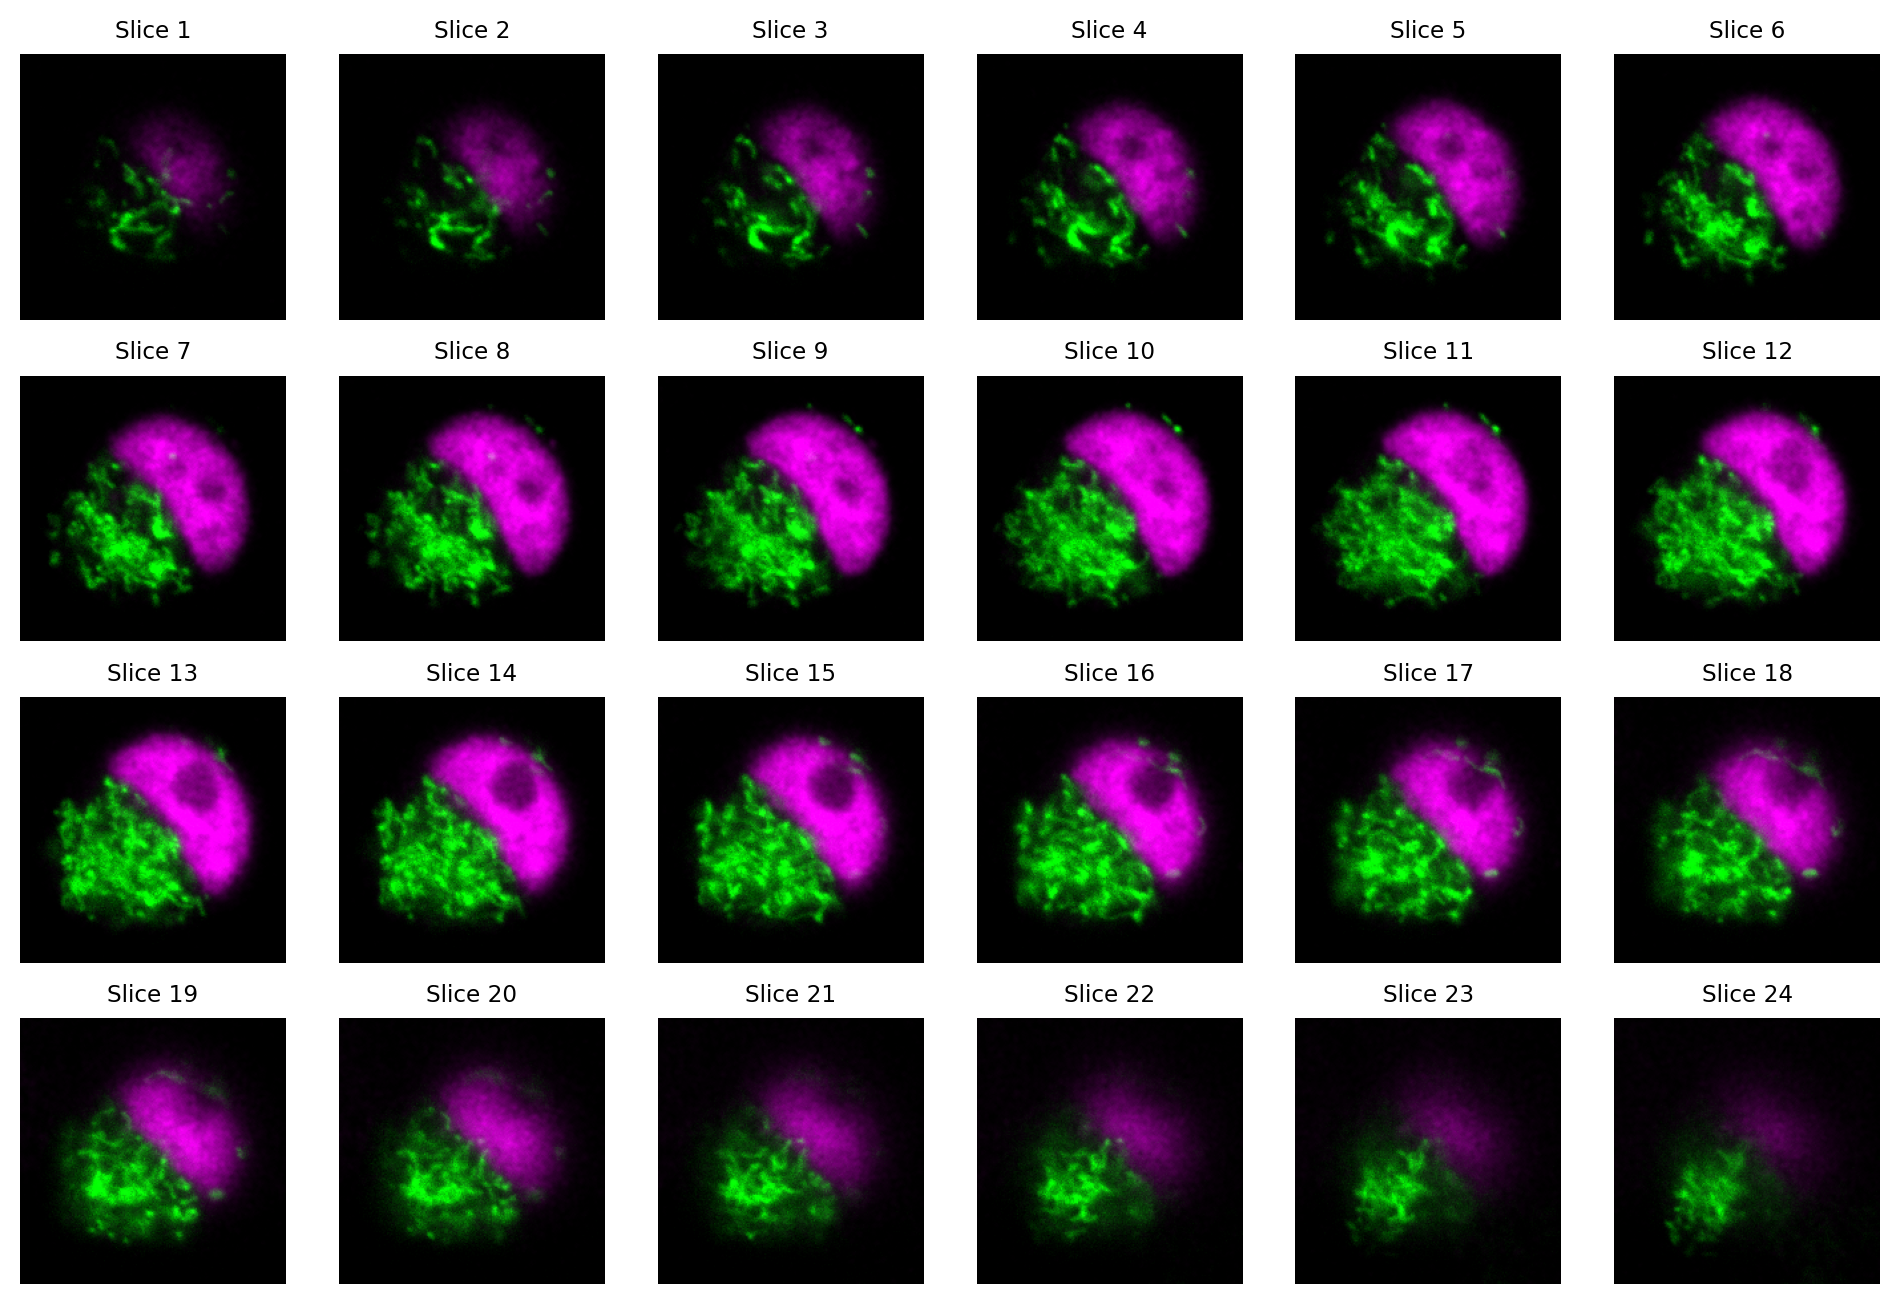

In [4]:
im = load_image('confocal-series.zip', volume=True)

# Drop last slice (for space reasons)
im = im[:-1, ...]

# Make the channels the last dimension
if im.shape[1] == 2:
    im = np.moveaxis(im, 1, -1)

# Drop some spatial info too
im = im[:, ::2, ::2, :]

# Convert to float32 and rescale per channel (to simplify display later)
def rescale_per_channel(im: np.ndarray, min_percentile=0.25, max_percentile=99.75):
    im = im.astype(np.float32)
    for c in range(im.shape[-1]):
        im[..., c] = im[..., c] - np.percentile(im[..., ], 0.25)
        im[..., c] = im[..., c] / np.percentile(im[..., ], 99.75)
    return im

im = rescale_per_channel(im)

# Not used, but uncomment to visualize what happens to noisier images
# rng = np.random.default_rng(100)
# im = im + rng.normal(scale=0.1, size=im.shape)
    
# Not used... but uncomment to test code works for 8-bit as well
# im = np.clip(im * 255, 0, 255).astype(np.uint8)

# Dimension order now ZHWC
n_slices = im.shape[0]

fig = create_figure(figsize=(12, 8))
for ii in range(n_slices):
    show_image(create_rgb(im[ii,...], ('green', 'magenta')), 
               pos=(4, n_slices//4, ii+1), vmin=0, vmax=1, title=f'Slice {ii+1}')

# plt.tight_layout()
glue_fig('fig_dimensions_slices', fig)

```{glue:figure} fig_dimensions_slices
---
align: center
name: fig-dimensions_slices
---

Visualizing the slices from a z-stack as separate images. Here, each slice has 2 channels.
```

`````{tab-set}

````{tab-item} Question
How many dimensions does the z-stack in {numref}`fig-dimensions_slices` have?

*Remember: we count channels as a dimension here!*
````

````{tab-item} Answer
The image is 4D: x, y, z, channels.
````
`````

Viewing many slices separately is cumbersome.

An efficient way to summarize the information in a z-stack is to compute a **z-projection**.

This generates a new image with the z-dimension essentially removed, i.e. a 3D image becomes 2D, or a 4D image becomes 3D.

The pixel values in the output image depend upon which function was used to compute the projection.
Perhaps the most common is to use a **maximum z-projection**.
For each pixel location in the new image, the maximum value is taken across all the z-slices at the corresponding pixel location in the original image (i.e. the same _x_, _y_, _c_ and _t_ coordinate, as appropriate).

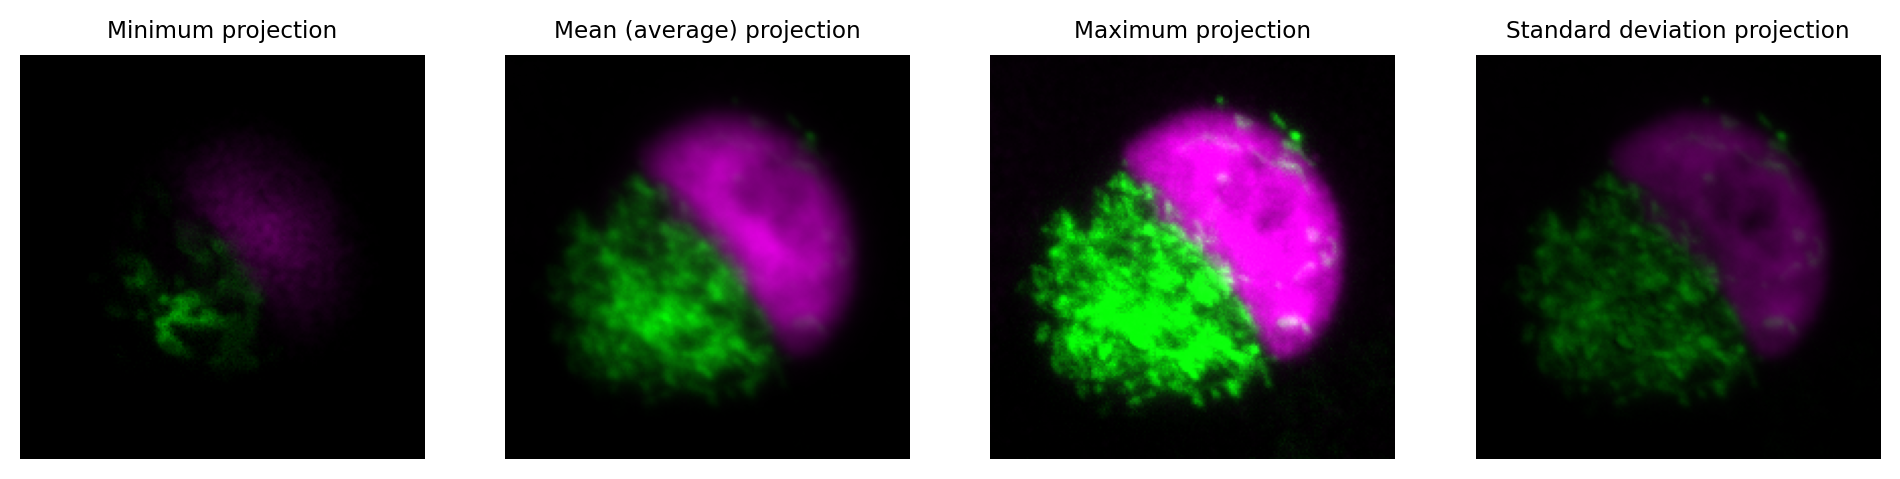

In [5]:
im = load_image('confocal-series.zip', volume=True)

# Drop last slice (for space reasons)
im = im[:-1, ...]

# Make the channels the last dimension
if im.shape[1] == 2:
    im = np.moveaxis(im, 1, -1)

# Drop some spatial info too
im = im[:, ::2, ::2, :]

# Convert to float32 and rescale per channel (to simplify display later)
im = rescale_per_channel(im)
    
fig = create_figure(figsize=(12, 4))

# Compute projections; retain the same dtype in the output
projections = [
    ('Minimum projection', im.min(axis=0).astype(im.dtype)),
    ('Mean (average) projection', im.mean(axis=0).astype(im.dtype)),
    ('Maximum projection', im.max(axis=0).astype(im.dtype)),
    ('Standard deviation projection', im.std(axis=0).astype(im.dtype)),
#     # We could justify rescaling the standard deviation for display, because it could be very different from the others
#     ('Standard deviation projection', rescale_per_channel(im.std(axis=0).astype(im.dtype))),
]
n_proj = len(projections)
for ii, (name, im_proj) in enumerate(projections):
    show_image(create_rgb(im_proj, ('green', 'magenta')), pos=(1, n_proj, ii+1), 
               title=name, vmin=0, vmax=1)

glue_fig('fig_dimensions_projection', fig)

```{glue:figure} fig_dimensions_projection
---
align: center
name: fig-dimensions_projection
---

Visualizing a z-stack using z-projections.
```

(sec_dims_orthogonal)=
### Orthogonal slices

Another useful way to visualize z-stack information is to use **orthogonal slices**.

Conceptually, the z-stack is viewed as a 3D block of pixels (or perhaps, 4D if we count channels).
We choose a single point in the image, and generate three orthogonal views on the image that pass through that point.
We can think of it as looking at the block from three different angles: from above, and from two adjacent sides.

This gives us 3 images, as shown in {numref}`fig-dimensions_orthogonal`.
Each image depends upon the single point through which the orthogonal views pass.

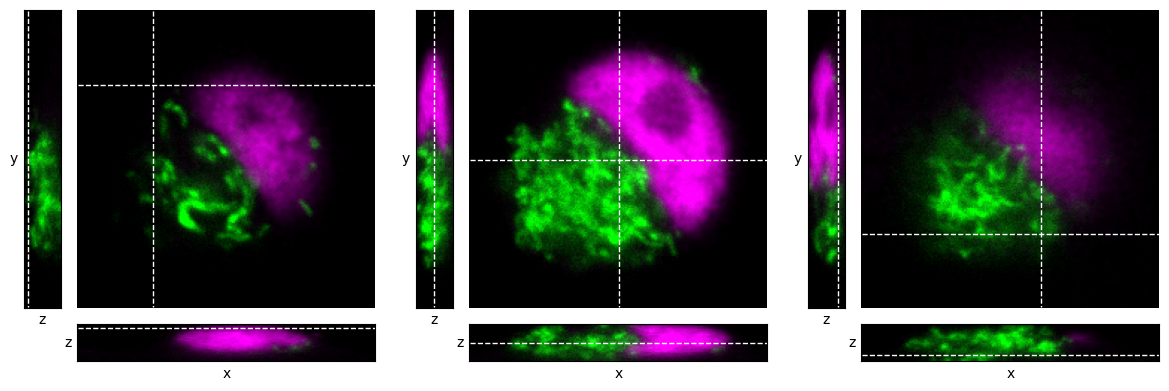

In [6]:
im = load_image('confocal-series.zip', volume=True)

# Make the channels the last dimension
if im.shape[1] == 2:
    im = np.moveaxis(im, 1, -1)

# Drop some spatial info since the detail doesn't help make the figure any clearer
im = im[:, ::2, ::2, :]

# Convert to float32 and rescale per channel (to simplify display later)
im = im.astype(np.float32)
for c in range(im.shape[-1]):
    im[..., c] = im[..., c] - np.percentile(im[..., ], 0.25)
    im[..., c] = im[..., c] / np.percentile(im[..., ], 99.75)

def show_orthogonal(im, axes, loc=None, projection=None, colors=('green', 'magenta'), show_slices=False, title=None):
    """
    Show orthogonal slices or projections.
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    if axes is None:
        fig = create_figure()
        ax = fig.gca()
    else:
        ax = axes
        
    if loc is None and projection is None:
        loc = tuple(s//2 for s in im.shape)
    
    # Create axes for orthogonal views
    divider = make_axes_locatable(ax)
    ax_xz = divider.append_axes("bottom", 0.5, pad=0.1, sharex=ax)
    ax_yz = divider.append_axes("left", 0.5, pad=0.1, sharey=ax)

    # Generate slices or projections
    if projection:
        imxy = projection(im, axis=0)
        imxz = projection(im, axis=2)
        imyz = np.moveaxis(projection(im, axis=1), 0, 1)
    else:
        imxy = im[loc[0],...]
        imxz = im[:, loc[1],...]
        imyz = np.moveaxis(im[:, :, loc[2],:], 0, 1)
        
    show_image(create_rgb(imyz, colors), 
                   axes=ax_yz, vmin=0, vmax=1)
    if show_slices:
        ax_yz.plot([loc[0], loc[0]], [0, im.shape[2]-1], 'w--', linewidth=1)
    ax_yz.set_xlabel('z')
    ax_yz.set_xticks([])
    ax_yz.set_ylabel('y', rotation=0, va='center', ha='right')
    ax_yz.set_yticks([])
    ax_yz.set_axis_on()

    show_image(create_rgb(imxy, colors), 
                   axes=ax,
                   vmin=0, vmax=1)
    if show_slices:
        row = loc[1]
        col = loc[2]
        ax.plot([0, im.shape[1]-1], [row, row], 'w--', linewidth=1)
        ax.plot([col, col], [0, im.shape[2]-1], 'w--', linewidth=1)

    show_image(create_rgb(imxz, colors),
                   axes=ax_xz,
                   vmin=0, vmax=1)
    if show_slices:
        ax_xz.plot([0, im.shape[1]-1], [loc[0], loc[0]], 'w--', linewidth=1)
    ax_xz.set_xlabel('x')
    ax_xz.set_xticks([])
    ax_xz.set_ylabel('z', rotation=0, va='center', ha='right')
    ax_xz.set_yticks([])
    ax_xz.set_axis_on()
    
    plt.tight_layout()
    
    if title:
        ax.set_title(title)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
show_orthogonal(im, show_slices=True, axes=axes[0], loc=(2, 50, 50))
show_orthogonal(im, show_slices=True, axes=axes[1])
show_orthogonal(im, show_slices=True, axes=axes[2], loc=(20, 150, 120))

glue_fig('fig_dimensions_orthogonal', fig)

```{glue:figure} fig_dimensions_orthogonal
---
align: center
name: fig-dimensions_orthogonal
---

Visualizing a z-stack using orthogonal slices at different locations within a z-stack, indicated by dashed lines.
```

The idea of orthogonal views and projections can be combined to give **orthogonal projections**, as shown in {numref}`fig-dimensions_orthogonal_projections`.
In this case, we don't need to choose a point through which to pass, because the projections do not depend upon a specific slice location; rather, all pixels contribute to each projection.

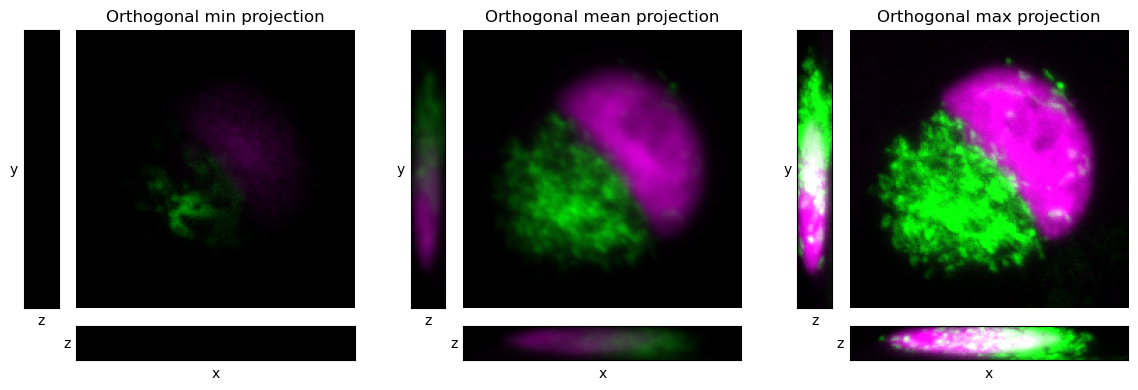

In [7]:
im = load_image('confocal-series.zip', volume=True)

# Make the channels the last dimension
if im.shape[1] == 2:
    im = np.moveaxis(im, 1, -1)

# Drop some spatial info since the detail doesn't help make the figure any clearer
im = im[:, ::2, ::2, :]

# Convert to float32 and rescale per channel (to simplify display later)
im = im.astype(np.float32)
for c in range(im.shape[-1]):
    im[..., c] = im[..., c] - np.percentile(im[..., ], 0.25)
    im[..., c] = im[..., c] / np.percentile(im[..., ], 99.75)
    
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
show_orthogonal(im, projection=np.min, title='Orthogonal min projection', axes=axes[0])
show_orthogonal(im, projection=np.mean, title='Orthogonal mean projection', axes=axes[1])
show_orthogonal(im, projection=np.max, title='Orthogonal max projection', axes=axes[2])

glue_fig('fig_dimensions_orthogonal_projections', fig)

```{glue:figure} fig_dimensions_orthogonal_projections
---
align: center
name: fig-dimensions_orthogonal_projections
---

Visualizing a z-stack using orthogonal projections.
```